In [1]:
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
from IPython import display

from HH import *

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 15
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["lines.linewidth"] = 1
loadHHLibrary()

HH library version is 3.0


In [2]:
now = datetime.datetime.now()
filename = "data/histomode_" + str(now) + ".csv"
outputfile = open(filename, "w+")
logfile = open(filename.replace("csv", "log"), "w+")

findAndConnect()
log = getInfo()
logfile.write(log + "\n")
print(log)


Searching for HydraHarp devices...
Dev_idx     Status
  0        S/N 1999999
  1        no device
  2        no device
  3        no device
  4        no device
  5        no device
  6        no device
  7        no device
Using device #0

Initializing the device...
Found Model HydraHarp 400 Part no 930020 Version 2.0
Device has 4 input channels.


In [3]:
log = setEverything(
    binning=0,  # you can change this
    offset=0,
    syncDivider=1,  # you can change this
    syncCFDZeroCross=0,  # you can change this (in mV)
    syncCFDLevel=600,  # you can change this (in mV)
    syncChannelOffset=-5000,  # you can change this (in ps, like a cable delay)
    inputCFDZeroCross=0,  # you can change this (in mV)
    inputCFDLevel=600,  # you can change this (in mV)
    inputChannelOffset=0,  # you can change this (in ps, like a cable delay)
)
print(log)
logfile.write(log + "\n")

# FIXME:
# Delay 1,2=332.5 ps
# Delay 3,4=341.0 ps
# TO calculate delay: measure dT1, swap cables, measure dT2
# dT1 = d1,2 + pathDelay
# dT2 = d1,2 - pathDelay
tryfunc(
    hhlib.HH_SetInputChannelOffset(ct.c_int(dev[0]), ct.c_int(1), ct.c_int(330)),
    "SetInputChannelOffset",
)


Calibrating...
Histogram length  : 65536
Binning           : 0
Offset            : 0
SyncDivider       : 1
SyncCFDZeroCross  : 0
SyncCFDLevel      : 600
InputCFDZeroCross : 0
InputCFDLevel     : 600
Resolution        : 1.0 ps



In [4]:
log = getRates()
print("\n" + log)
logfile.write(log + "\n")

log = getWarnings()
print("\n" + log)
logfile.write(log + "\n")

tryfunc(
    hhlib.HH_SetStopOverflow(ct.c_int(dev[0]), ct.c_int(0), ct.c_int(10000)),
    "SetStopOverflow",
)  # for example only


Syncrate=40000120/sCountrate[0]=0/s
Countrate[1]=0/s
Countrate[2]=1080/s
Countrate[3]=0/s


WARNING_SYNC_RATE_TOO_HIGH: 
The pulse rate at the sync input is too high. 
If your sync source is periodic you can try 
setting a larger sync divider. 





In [ ]:
tacq = 10000  # Measurement time in millisec, you can change this
log, histLen, numChannels, counts = measureAllInputs(tacq)
print(log)
logfile.write(log+"\n")

for j in range(0, histLen):
    for i in range(0, numChannels):
        outputfile.write("%5d " % counts[i][j])
    outputfile.write("\n")

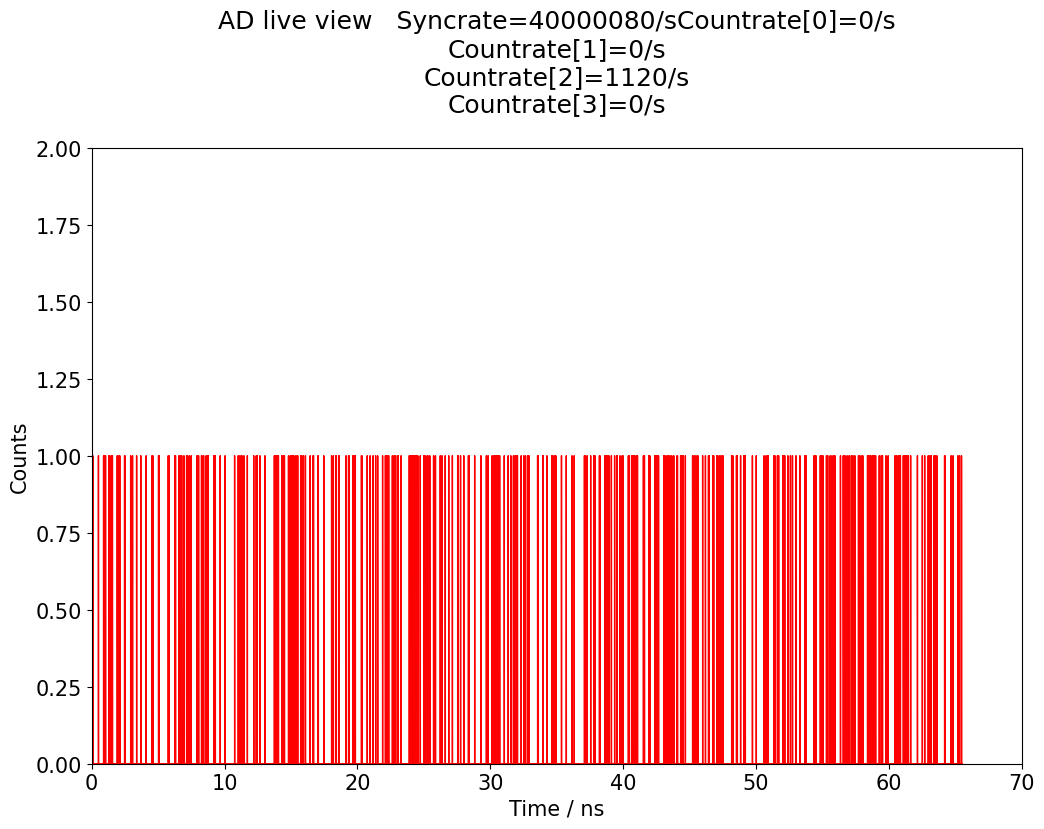

KeyboardInterrupt: 

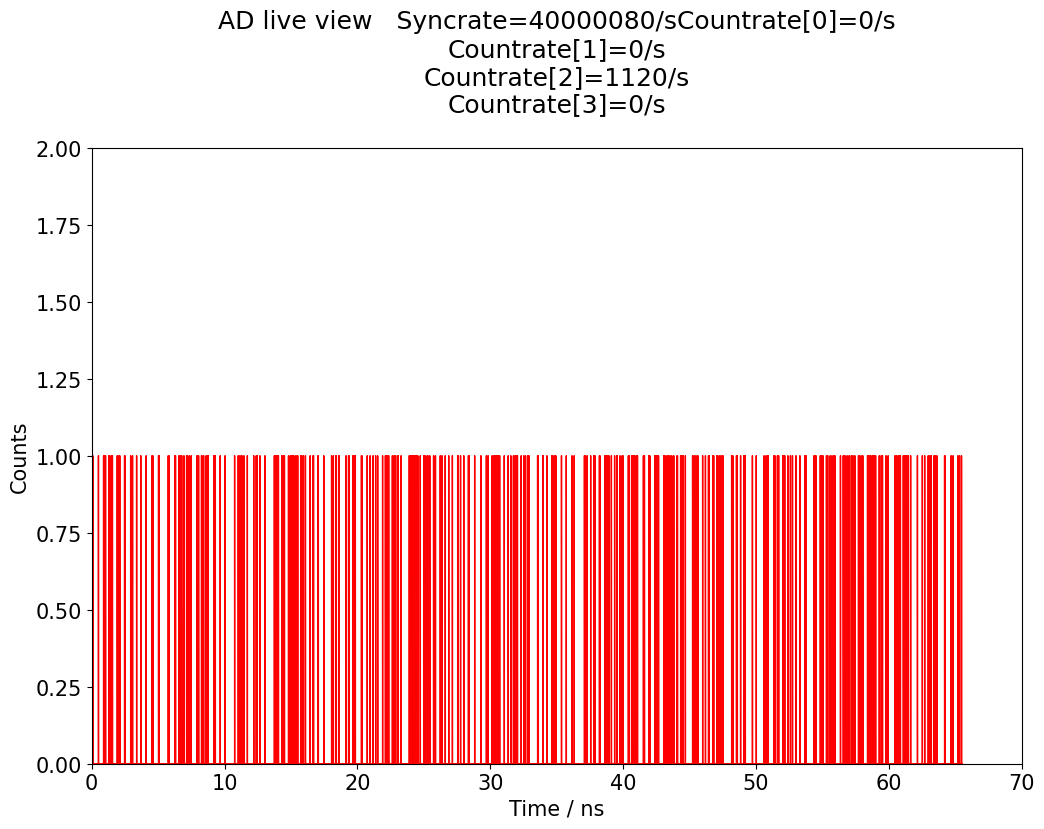

In [10]:
"""
| (_)_   _____  __   _(_) _____      __
| | \ \ / / _ \ \ \ / / |/ _ \ \ /\ / /
| | |\ V /  __/  \ V /| |  __/\ V  V /
|_|_| \_/ \___|   \_/ |_|\___| \_/\_/
"""


def draw(ax, i, hdisplay):
    T = np.linspace(0, 1, 100)
    if ax.lines:
        for line in ax.lines:
            log, histLen, numChannels, data = measureAllInputs(1000)
            ch3 = [data[2][i] for i in range(histLen)]
            ax.set_ylim(0, max(ch3) + 1)
            T = np.linspace(0, len(ch3), len(ch3)) / 1000

            line.set_xdata(T)
            line.set_ydata(ch3)

            log = getRates()
            ax.set_title("AD live view   " + log)
    else:
        ax.plot(T, T * 0, "r")
    hdisplay.update(fig)


fig, ax = plt.subplots(1, 1)
ax.set_xlim(0, 70)
ax.set_ylim(0, 3)
ax.set_xlabel("Time / ns")
ax.set_ylabel("Counts")

hdisplay = display.display("", display_id=True)

for i in range(100):
    draw(ax, i, hdisplay=hdisplay)

plt.close(fig)

In [ ]:
# writing to file and quitting
closeDevices()
outputfile.close()
logfile.close()

In [ ]:
data = np.loadtxt(filename)
row1 = data[:, 0]
row2 = data[:, 1]
row3 = data[:, 2]
row4 = data[:, 3]

T = np.linspace(0, len(row1), len(row1)) / 1000


plt.plot(T, row1, label="Channel 1", color="#1f77b4")
plt.plot(T, row2, label="Channel 2", color="#ff7f0e")
plt.plot(T, row3, label="Channel 3", color="black")
plt.plot(T + 0.342, row4, label="Channel 4", color="purple")

# bins_time = np.linspace(min(T), max(T), 5000)  # 5 przedziałów czasowych
# binnin_res=(bins_time[1]-bins_time[0])*1e3 #ps
# print("Bins",binnin_res," ps")
# plt.hist(T, bins=bins_time, weights=row1,color="red")

plt.legend()
plt.xlim(10, 20)
plt.xlabel("Time / ns")
plt.ylabel("Counts")
plt.yscale("log")

# plt.title("3C4Z")
plt.savefig(filename.replace(".csv", ".png"))

In [ ]:
dataA = np.loadtxt("data/histomode_2025-09-10 16:37:59.611794.csv")
# dataB = np.loadtxt("data/histomode_2025-09-10 15:50:40.505662.csv", skiprows=9)

ch1A = dataA[:, 2]
ch2A = dataA[:, 3]

# ch1B = dataB[:, 2]
# ch2B = dataB[:, 3]


def f(data):
    maxi = 0
    ptrMaxi = 0
    for i in range(0, 20000):
        if data[i] > maxi:
            maxi = data[i]
            ptrMaxi = i
    return ptrMaxi


print(f(ch1A), f(ch2A), -f(ch2A) + f(ch1A))
# print(f(ch1B), f(ch2B), -f(ch2B) + f(ch1B))

# hpd = max('''-f(ch2B) + f(ch1B),''' -f(ch2A) + f(ch1A))
# hmd = min('''-f(ch2B) + f(ch1B),''' -f(ch2A) + f(ch1A))

# print("Hydra's delay:", (hpd + hmd) / 2)
# print("Path delay:", (hpd - hmd) / 2)